# Conda Environment Setup

All environment settings are written in ```environment.yml```. You can create the environment by running the following command in the terminal:

```shell
conda env create -f environment.yml
```

# Get Started

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Plot the data

Plot a line graph showing the sequence in amp_data, and a histogram of the amplitudes in this sequence. 

Include the code for your plots, with one to three sentences about anything you notice that might be important for modelling these data.

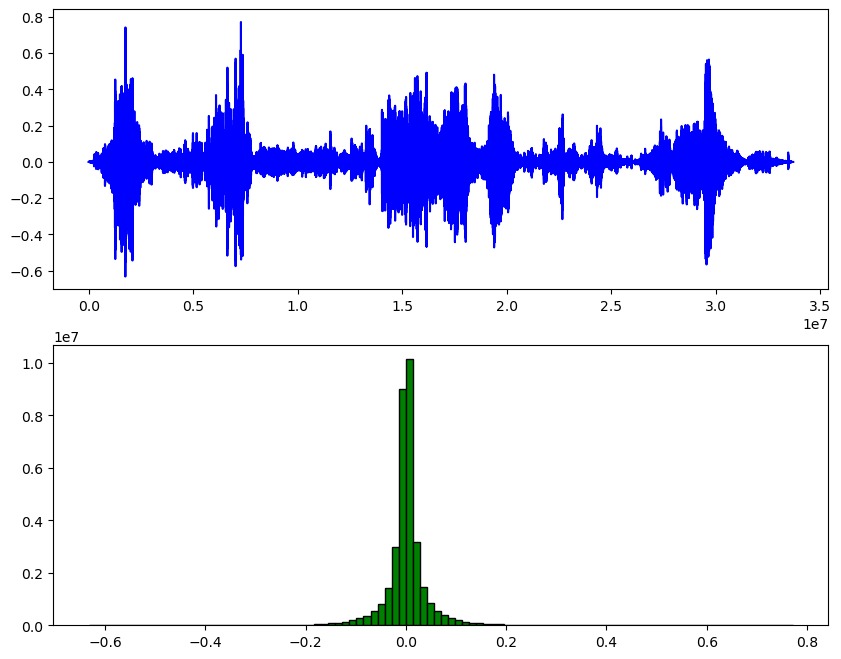

In [3]:
amp_data = np.load('amp_data.npz')['amp_data']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Line graph of the sequence
ax1.plot(amp_data, color='blue')

# Histogram of the amplitudes
ax2.hist(amp_data, bins=100, color='green', edgecolor='black')

plt.show()

## Create dataset

Include your code for creating the six arrays above from the original amp_data array. Your answers to future questions should assume these arrays exist, rather than relisting the code from this part.

In [4]:
# Define the number of columns for reshaping (R*21 matrix)
R = 21

# Calculate how many elements we can keep for reshaping
num_rows = len(amp_data) // R

# Truncate the amp_data to fit perfectly into a matrix of shape (num_rows, R)
amp_data_truncated = amp_data[:num_rows * R]

# Reshape the data into (num_rows, 21) matrix
amp_matrix = amp_data_truncated.reshape(num_rows, R)

# Shuffle the rows of the matrix
amp_matrix_shuffled = np.random.permutation(amp_matrix)

# Split the data into training (70%), validation (15%), and testing (15%)
train_size = int(0.7 * num_rows)
val_size = int(0.15 * num_rows)

# Training data
X_shuf_train = amp_matrix_shuffled[:train_size, :-1]
y_shuf_train = amp_matrix_shuffled[:train_size, -1]

# Validation data
X_shuf_val = amp_matrix_shuffled[train_size:(train_size + val_size), :-1]
y_shuf_val = amp_matrix_shuffled[train_size:(train_size + val_size), -1]

# Testing data
X_shuf_test = amp_matrix_shuffled[(train_size + val_size):, :-1]
y_shuf_test = amp_matrix_shuffled[(train_size + val_size):, -1]

# Saving the random seed for future reproducibility
random_seed = 42

# Displaying the shapes of the created datasets
(X_shuf_train.shape, y_shuf_train.shape, X_shuf_val.shape, y_shuf_val.shape, X_shuf_test.shape, y_shuf_test.shape)

((1123775, 20), (1123775,), (240809, 20), (240809,), (240810, 20), (240810,))

# Curve fitting on a snippet of audio

Given just one row of inputs, we could fit a curve of amplitude against time through the 20 points, and extrapolate it one step into the future. Plot the points in one row of your ```X_shuf_train``` data against the numbers $t = \frac{0}{20}, ..., \frac{19}{20}$, representing times. We can fit this sequence with various linear regression models, and extrapolate them to predict the 21st time step at time $\frac{20}{20} = 1$. Indicate the point you’re predicting from ```y_shuf_train``` on the plot at $t = 1$.

First fit and plot a straight line to the 20 training points. Then fit a quartic polynomial, by expanding each time $t$ to a feature vector $\phi(t) = [1, t, t^2, t^3, t^4]^T$ and fitting a linear model by least squares. Plot both fits between $t = 0$ and $t = 1$.


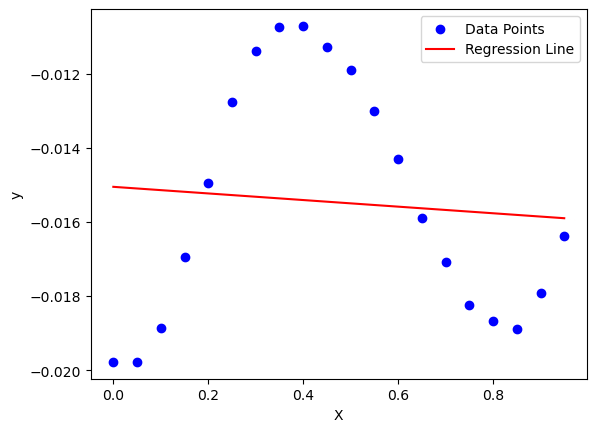

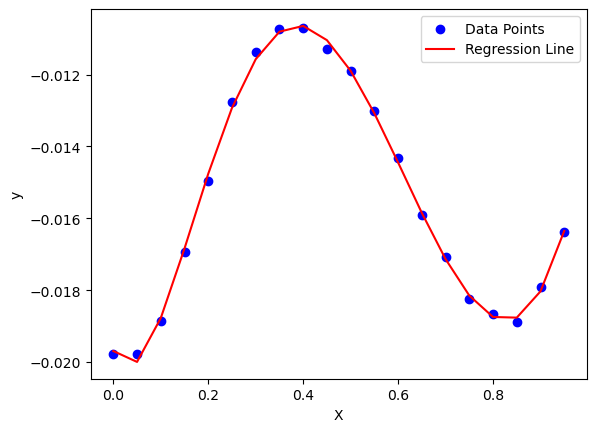

In [5]:
# y = wt + b
t_values = np.linspace(0, 19 / 20, 20)

# Fit a straight line (linear model)
row_index = 115
A_linear = np.vstack([t_values, np.ones(len(t_values))]).T
coeffs_linear = np.linalg.lstsq(A_linear, X_shuf_train[row_index], rcond=None)[0]
linear_fit = A_linear @ coeffs_linear


plt.scatter(t_values, X_shuf_train[row_index], color="blue", label="Data Points")
plt.plot(t_values, linear_fit, color="red", label="Regression Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()

A_quartic = np.vstack([t_values**6, t_values**5, t_values**4, t_values**3, t_values**2, t_values, np.ones(len(t_values))]).T
coeffs_quartic = np.linalg.lstsq(A_quartic, X_shuf_train[row_index], rcond=None)[0]
quartic_fit = A_quartic @ coeffs_quartic


plt.scatter(t_values, X_shuf_train[row_index], color="blue", label="Data Points")
plt.plot(t_values, quartic_fit, color="red", label="Regression Line")
plt.xlabel("X")
plt.ylabel("y")
plt.legend()
plt.show()


In [6]:
def Phi(C, K):
    t_values = np.linspace(1 - C/20, 1 - 1/20, C)
    Phi = np.ones((C, K))
    for i in range(len(t_values)):
        for j in range(K):
            Phi[i][j] = t_values[i]**j
    return Phi

print(Phi(20, 5))

[[1.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [1.0000000e+00 5.0000000e-02 2.5000000e-03 1.2500000e-04 6.2500000e-06]
 [1.0000000e+00 1.0000000e-01 1.0000000e-02 1.0000000e-03 1.0000000e-04]
 [1.0000000e+00 1.5000000e-01 2.2500000e-02 3.3750000e-03 5.0625000e-04]
 [1.0000000e+00 2.0000000e-01 4.0000000e-02 8.0000000e-03 1.6000000e-03]
 [1.0000000e+00 2.5000000e-01 6.2500000e-02 1.5625000e-02 3.9062500e-03]
 [1.0000000e+00 3.0000000e-01 9.0000000e-02 2.7000000e-02 8.1000000e-03]
 [1.0000000e+00 3.5000000e-01 1.2250000e-01 4.2875000e-02 1.5006250e-02]
 [1.0000000e+00 4.0000000e-01 1.6000000e-01 6.4000000e-02 2.5600000e-02]
 [1.0000000e+00 4.5000000e-01 2.0250000e-01 9.1125000e-02 4.1006250e-02]
 [1.0000000e+00 5.0000000e-01 2.5000000e-01 1.2500000e-01 6.2500000e-02]
 [1.0000000e+00 5.5000000e-01 3.0250000e-01 1.6637500e-01 9.1506250e-02]
 [1.0000000e+00 6.0000000e-01 3.6000000e-01 2.1600000e-01 1.2960000e-01]
 [1.0000000e+00 6.5000000e-01 4.2250000e-01 2.74625

Provide code for a function ```make_vv(C, K)``` that returns the vector $v$ that you derived in part a) for a model with $K$ features and a context of $C$ previous amplitudes, using the function from the previous part.

In [7]:
def make_vv(C, K):
    phi = Phi(C, K)
    phi_t_1 = np.ones((1, K))
    vv = phi_t_1 @ np.linalg.inv(phi.T @ phi) @ phi.T
    return vv
    
make_vv(20, 5)

array([[ 0.25      , -0.06578947, -0.19736842, -0.20252838, -0.13093395,
        -0.02412281,  0.08449432,  0.16963364,  0.21413829,  0.20897833,
         0.15325077,  0.05417957, -0.07288442, -0.20446336, -0.30895253,
        -0.34662023, -0.26960784, -0.02192982,  0.46052632,  1.25      ]])

Include a short demonstration that using two vectors from ```make_vv(C, K)```, for appropriate $C$ and $K$, you can make the same predictions at time $t=1$ as the linear and quartic curves you fitted in Q2.

In [8]:
def squared_error(vv, context_data, true_value):
    # Predict value at t=1
    predicted_value = vv @ context_data
    return np.sum((predicted_value - true_value)**2)

# Define ranges for C (context lengths) and K (basis functions)
C_values = [10, 15, 20] 
K_values = [2, 3, 5, 7]

best_C = None
best_K = None
min_error = float('inf')

# Loop over each combination of C and K
for C in C_values:
    for K in K_values:
        print(f"Evaluating C = {C}, K = {K}")
        vv = make_vv(C, K)

        total_squared_error = 0
        
        for i in range(len(X_shuf_test)):
            context_data = X_shuf_test[i][:C]
            true_value = y_shuf_test[i]
            
            total_squared_error += squared_error(vv, context_data, true_value)
        
        avg_squared_error = total_squared_error / len(X_shuf_test)
        print(avg_squared_error)
        if avg_squared_error < min_error:
            min_error = avg_squared_error
            best_C = C
            best_K = K

print(f"Best C: {best_C}, Best K: {best_K}, Minimum squared error: {min_error}")


Evaluating C = 10, K = 2
0.0017758800677006457
Evaluating C = 10, K = 3
0.0015991738390278142
Evaluating C = 10, K = 5
0.0014397755751797505
Evaluating C = 10, K = 7
0.0016836365838936997
Evaluating C = 15, K = 2
0.001241505848401598
Evaluating C = 15, K = 3
0.001076653122208488
Evaluating C = 15, K = 5
0.0007468387681587474
Evaluating C = 15, K = 7
0.0008192665180173264
Evaluating C = 20, K = 2
0.0004930384791980288
Evaluating C = 20, K = 3
0.0003352900100115273
Evaluating C = 20, K = 5
0.00021666677239696108
Evaluating C = 20, K = 7
0.00021338006260828625
Best C: 20, Best K: 7, Minimum squared error: 0.00021338006260828625


In [9]:
C = 20
K = 5
vv = make_vv(C, K)
total_squared_error = 0

name_sets = ["Training", "Validation", "Testing"]
x_sets = [X_shuf_train, X_shuf_val, X_shuf_test]
y_sets = [y_shuf_train, y_shuf_val, y_shuf_test]

for i in range(3):
    dataset = x_sets[i]
    label = y_sets[i]
    for j in range(len(dataset)):
        context_data = dataset[j][:C]
        true_value = label[j]
            
        total_squared_error += squared_error(vv, context_data, true_value)
        
    avg_squared_error = total_squared_error / len(dataset)
        
    print(f"{name_sets[i]} dataset, Average squared error: {avg_squared_error}")


Training dataset, Average squared error: 0.00021570478198349903
Validation dataset, Average squared error: 0.001223796483454315
Testing dataset, Average squared error: 0.0014404581738509642


# Fitting linear predictors across many snippets:
It’s possible we could do better by picking different basis functions. However, no matter which basis functions we pick, a linear model fitted by least squares will predict the next amplitude using a linear combination of the previous amplitudes.

Given a large dataset, we can try to fit a good linear combination directly, without needing to specify basis functions. Using standard linear least squares fitting code, we can find the vector $v$ that minimizes $$\sum_{n=1}(y^{(n)} - v^\top x^{(n)})^2$$
on the training set. Again, $y^{(n)}$ is the $n-$th amplitude to predict, based on a history of previous amplitudes in $x^{(n)}$.

We can choose to make the prediction based on a shorter history than all of the previous 20 amplitudes available. For $C=1, 2, ..., 20$, fit vectors $v^{(c)}$, each of length $C$, that can combine $C$ previous amplitudes to predict the next amplitude.

In [10]:
results = []
for C in range(1, 21):
    X_val_C = X_shuf_val[:, :C]
    
    v_C, residuals, rank, s = np.linalg.lstsq(X_val_C, y_shuf_val, rcond=None)
    
    # Calculate the predicted values using the fitted vector v^{(C)}
    y_pred = X_val_C @ v_C
    
    # Compute the mean squared error for this C
    mse_C = np.mean((y_pred - y_shuf_val)**2)
    
    results.append((C, mse_C))

    print(f"Context length C={C}, MSE={mse_C:.6f}")

best_C, best_mse = min(results, key=lambda x: x[1])

print(f"\nBest context length C: {best_C}, with the minimum MSE: {best_mse:.6f}")

Context length C=1, MSE=0.001498
Context length C=2, MSE=0.001460
Context length C=3, MSE=0.001423
Context length C=4, MSE=0.001389
Context length C=5, MSE=0.001354
Context length C=6, MSE=0.001316
Context length C=7, MSE=0.001271
Context length C=8, MSE=0.001220
Context length C=9, MSE=0.001164
Context length C=10, MSE=0.001095
Context length C=11, MSE=0.001014
Context length C=12, MSE=0.000917
Context length C=13, MSE=0.000799
Context length C=14, MSE=0.000669
Context length C=15, MSE=0.000529
Context length C=16, MSE=0.000387
Context length C=17, MSE=0.000251
Context length C=18, MSE=0.000133
Context length C=19, MSE=0.000052
Context length C=20, MSE=0.000008

Best context length C: 20, with the minimum MSE: 0.000008


Take the predictor with the best validation error and compare it to the best polynomial model from Q3 on the test set. Include your code, and the two test set numbers. Which approach is better?



In [ ]:
def fit_best_linear_model(C, X_train, y_train):
    X_train_C = X_train[:, :C]
    v_C, residuals, rank, s = np.linalg.lstsq(X_train_C, y_train, rcond=None)
    return v_C

def fit_best_polynomical_model(C, K):
    return make_vv(C, K)

C = 20
K = 5
v_best_linear_model = fit_best_linear_model(C, X_shuf_test, y_shuf_test)
y_linear_pred = X_shuf_test[:, :C] @ v_best_linear_model

v_best_poly_model = fit_best_polynomical_model(C, K)
y_poly_pred = X_shuf_test[:, :C] @ v_best_poly_model.T

mse_linear = np.mean((y_linear_pred - y_shuf_test)**2)
mse_poly = np.mean((y_poly_pred - y_shuf_test)**2)

print(f"Test set MSE with the best linear model (C=20): {mse_linear:.6f}")
print(f"Test set MSE with the best polynomial model (K=5): {mse_poly:.6f}")

if mse_linear < mse_poly:
    print("The linear model performs better on the test set.")
elif mse_linear == mse_poly:
    print("Both models perform equally well on the test set.")
else:
    print("The polynomial model performs better on the test set.")

Plot a histogram of the residuals on the validation data for your best model, and compare it to the histogram of amplitudes you plotted in Q1. Include your code, and a one or two sentence comment on what you observe.

In [ ]:
X_val_C = X_shuf_val[:, :C]
y_pred_val = X_val_C @ v_best_poly_model.T
residuals = y_shuf_val - y_pred_val

plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=30, color='blue', alpha=0.7, label="Residuals")
plt.title("Histogram of Residuals (Validation Data)")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

